<b>Deep Noise Suppression Task </b><br>
Inspired by medium article: https://medium.com/analytics-vidhya/noise-suppression-using-deep-learning-6ead8c8a1839

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,Conv1DTranspose,Concatenate,Input
import matplotlib.pyplot as plt
import numpy as np
import IPython.display
import  glob
from tqdm.notebook import tqdm

%matplotlib inline  

In [3]:
# Load clean and noisy training data
clean_sounds = glob.glob('./data/DS_10283_1942/clean_trainset_wav/*.wav')
noisy_sounds = glob.glob('./data/DS_10283_1942/noisy_trainset_wav/*.wav')

clean_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(clean_sounds[0]),desired_channels=1)
for ii in tqdm(clean_sounds[1:7000]):
    new_clean_file,_  = tf.audio.decode_wav(tf.io.read_file(ii), desired_channels=1)
    clean_sounds_list = tf.concat((clean_sounds_list,new_clean_file), axis=0)

noisy_sounds_list,_ = tf.audio.decode_wav(tf.io.read_file(noisy_sounds[0]),desired_channels=1)
for ii in tqdm(noisy_sounds[1:7000]):
    new_noisy_file,_  = tf.audio.decode_wav(tf.io.read_file(ii), desired_channels=1)
    noisy_sounds_list = tf.concat((noisy_sounds_list, new_noisy_file), axis=0)

print(f" Shape of the clean data: {clean_sounds_list.shape}\n Shape of the noisy data: {noisy_sounds_list.shape}\n")

  0%|          | 0/6999 [00:00<?, ?it/s]

  0%|          | 0/6999 [00:00<?, ?it/s]

 Shape of the clean data: (328307110, 1)
 Shape of the noisy data: (328307110, 1)



In [4]:
# split the samples in equal batch size [samples]
batch_size = 12000

clean_train, noisy_train =[], []
for ii in tqdm(range(0,clean_sounds_list.shape[0]-batch_size,batch_size)):
    clean_train.append(clean_sounds_list[ii:ii+batch_size])
    noisy_train.append(noisy_sounds_list[ii:ii+batch_size])

clean_train = tf.stack(clean_train)
noisy_train = tf.stack(noisy_train)

print(f" Shape of the clean train data: {clean_train.shape}\n Shape of the noisy train data: {noisy_train.shape}\n")

  0%|          | 0/27358 [00:00<?, ?it/s]

 Shape of the clean train data: (27358, 12000, 1)
 Shape of the noisy train data: (27358, 12000, 1)



In [ ]:
# Visualize some clean and noisy examples from dataset
import librosa.display

index = 102
plt.subplot(2,1,1)
librosa.display.waveplot(np.squeeze(clean_train[index].numpy(),axis=-1))
plt.grid()
plt.title(f"Training Clean example - {index}")

plt.subplot(2,1,2)
librosa.display.waveplot(np.squeeze(noisy_train[index].numpy(),axis=-1))
plt.grid()
plt.title(f"Training Noisy example - {index}")

In [ ]:
# Create TF dataset for the pipeline
def get_dataset(x_train,y_train):
    dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
    dataset = dataset.shuffle(100).batch(64,drop_remainder=True)
    return dataset

train_samples = 25000
test_samples  = 5e3 # or rest of dataset

train_dataset = get_dataset(noisy_train[:train_samples],clean_train[:train_samples])
test_dataset  = get_dataset(noisy_train[train_samples:],clean_train[train_samples:])

<b>Create the Convolutional model</b><br>
Based on S.Pascual SEGAN model

In [10]:
inp = Input(shape=(batch_size,1))
c1 = Conv1D(2,32,2, 'same',activation='relu')(inp)
c2 = Conv1D(4,32,2, 'same',activation='relu')(c1)
c3 = Conv1D(8,32,2, 'same',activation='relu')(c2)
c4 = Conv1D(16,32,2,'same',activation='relu')(c3)
c5 = Conv1D(32,32,2,'same',activation='relu')(c4)

dc1 = Conv1DTranspose(32,32,1,padding='same')(c5)
conc = Concatenate()([c5,dc1])
dc2 = Conv1DTranspose(16,32,2,padding='same')(conc)
conc = Concatenate()([c4,dc2])
dc3 = Conv1DTranspose(8,32,2,padding= 'same')(conc)
conc = Concatenate()([c3,dc3])
dc4 = Conv1DTranspose(4,32,2,padding= 'same')(conc)
conc = Concatenate()([c2,dc4])
dc5 = Conv1DTranspose(2,32,2,padding= 'same')(conc)
conc = Concatenate()([c1,dc5])
dc6 = Conv1DTranspose(1,32,2,padding= 'same')(conc)
conc = Concatenate()([inp,dc6])
dc7 = Conv1DTranspose(1,32,1,padding= 'same',activation='linear')(conc)
model = tf.keras.models.Model(inp,dc7)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6000, 2)      66          ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 3000, 4)      260         ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1500, 8)      1032        ['conv1d_1[0][0]']               
                                                                                              

In [ ]:
# Get the digram of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
# train the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.002),loss=tf.keras.losses.MeanAbsoluteError())
history = model.fit(train_dataset, epochs=20)

In [5]:
# Test samples
from IPython.display import Audio

index = 90
# noisy signal
Audio(np.squeeze(noisy_train[index].numpy()), rate=16000)

In [ ]:
# DNS-ed signal
Audio(tf.squeeze(model.predict(tf.expand_dims(tf.expand_dims(noisy_train[index],-1),0))), rate=16000)

In [ ]:
# Evaluate test dataset
model.evaluate(test_dataset)

In [ ]:
# Save the weights of net in .h5 format
model.save('saved_model/DNS_model.h5')

<b>Inference</b> <br>
Prepare signals for inference with specific batch size

In [6]:
def get_audio(path):
    audio,_ = tf.audio.decode_wav(tf.io.read_file(path))
    return audio

In [7]:
def inference_preprocess(path):
    audio     = get_audio(path)
    audio_len = audio.shape[0]
    batches   = []
    for ii in range(0,audio_len-batch_size,batch_size):
        batches.append(audio[ii:ii+batch_size])
    
    batches.append(audio[-batch_size:])
    diff = audio_len - (ii + batch_size)
    return tf.stack(batches), diff

In [8]:
def predict(path):
    test_data, diff = inference_preprocess(path)
    predictions     = model.predict(test_data)
    final_op        = tf.reshape(predictions[:-1],((predictions.shape[0]-1)*predictions.shape[1],1))
    final_op        = tf.concat((final_op, predictions[-1][-diff:]),axis=0)
    return final_op

In [13]:
# Noisy and Cleaned-out using using DNS in inference mode
index = 3001
model.load_weights('saved_model/DNS_model.h5')

Audio(np.squeeze(get_audio(noisy_sounds[index]).numpy(),-1),rate=16000)

In [14]:
# Cleaned-out signal
Audio(tf.squeeze(predict(noisy_sounds[index]).numpy(),-1),rate=16000)

1/1 [==============================] - 0s 109ms/step


In [15]:
%%timeit
tf.squeeze(predict(noisy_sounds[index]))

1/1 [==============================] - 0s 49ms/step
109 ms ± 4.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


1/1 [==============================] - 0s 41ms/step


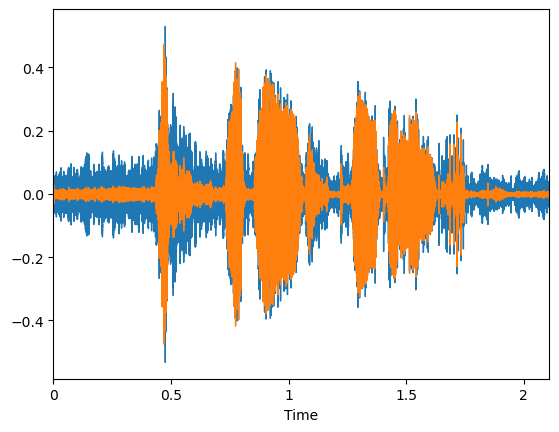

In [16]:
# Display the noisy and cleaned signals
import librosa.display
librosa.display.waveplot(np.squeeze(get_audio(noisy_sounds[index]).numpy(),-1))
librosa.display.waveplot(np.squeeze(predict(noisy_sounds[index])))

<b>Quantization and TF Lite conversion</b>

In [17]:
lite_model = tf.lite.TFLiteConverter.from_keras_model(model)
lite_model.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = lite_model.convert()

INFO:tensorflow:Assets written to: C:\Users\aroum\AppData\Local\Temp\tmpimj8t7fy\assets


INFO:tensorflow:Assets written to: C:\Users\aroum\AppData\Local\Temp\tmpimj8t7fy\assets


In [19]:
with open('saved_model/TFLiteModel.tflite','wb') as f:
  f.write(tflite_model_quant)